# load the data into a Pandas dataframe.

In [ ]:
import pandas as pd

df = pd.read_csv('jena_climate_2009_2016.csv')

time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
series = df['T (degC)'][5::6]
series.index = time[5::6]

We create a matrix of lagged values out of the time series using a window of a specific length.

In our prediction models, the last column would serve as the labels and the rest of the columns as the predictors.


In our case, it would make sense to chose a window size of one day because of the seasonality in daily data.

In [ ]:
import numpy as np

# function for generating the lagged matrix
def split_sequence(sequence, window_size):
    X = []
    y = []
    # for all indexes
    for i in range(len(sequence)):
        end_idx = i + window_size
        # exit condition
        if end_idx > len(sequence) - 1:
            break
        # get X and Y values
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


train = series[:-int(len(series)/10)]
test = series[-int(len(series)/10):]
X_train, y_train = split_sequence(train, window_size=24)
X_test, y_test = split_sequence(test, window_size=24)

# Modelling Time Series Using Regression

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(63058, 24) (63058,) (6985, 24) (6985,)


In [ ]:
print(X_train.shape)
print(y_train.shape)


(63058, 24)
(63058,)


In [ ]:
import statsmodels.api as sm

# train Ordinary Least Squares model
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.376e+05
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:15:56   Log-Likelihood:                -70605.
No. Observations:               63058   AIC:                         1.413e+05
Df Residuals:                   63033   BIC:                         1.415e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0317      0.005      6.986      0.0

A Durbin-Watson value greater than 2 suggests that our series has no autocorrelation.


#Checking for normality can be done with the following tests:


Jarque-Bera test

Shapiro-Wilk test

Koglomorov-Smirnov test

In [ ]:
from scipy import stats

# get values of the residuals
residual = result.resid

# run tests and get the p values
print('p value of Jarque-Bera test is: ', stats.jarque_bera(residual)[1])
print('p value of Shapiro-Wilk test is: ', stats.shapiro(residual)[1])
print('p value of Kolmogorov-Smirnov test is: ', stats.kstest(residual, 'norm')[1])

p value of Jarque-Bera test is:  0.0
p value of Shapiro-Wilk test is:  0.0
p value of Kolmogorov-Smirnov test is:  0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


For heteroscedasticity, we will use the following tests:

Breusch-Pagan test

White Test

In [ ]:
import statsmodels.stats.api as sms

print('p value of Breusch–Pagan test is: ', sms.het_breuschpagan(result.resid, result.model.exog)[1])
print('p value of White test is: ', sms.het_white(result.resid, result.model.exog)[1])

p value of Breusch–Pagan test is:  2.996182722664035e-246
p value of White test is:  0.0


Assuming a significance level of 0.05, the two tests suggest that our series is heteroscedastic.



Our series is neither homoscedastic nor normally distributed. Lucky for us, unlike OLS, generalized least squares accounts for these residual errors.

In [ ]:
import statsmodels.api as sm

# train Ordinary Least Squares model
X_train = sm.add_constant(X_train)
model = sm.GLS(y_train, X_train)
result = model.fit()

print(result.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            GLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.376e+05
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:16:04   Log-Likelihood:                -70605.
No. Observations:               63058   AIC:                         1.413e+05
Df Residuals:                   63033   BIC:                         1.415e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0317      0.005      6.986      0.0

We can get our predictions as follows:

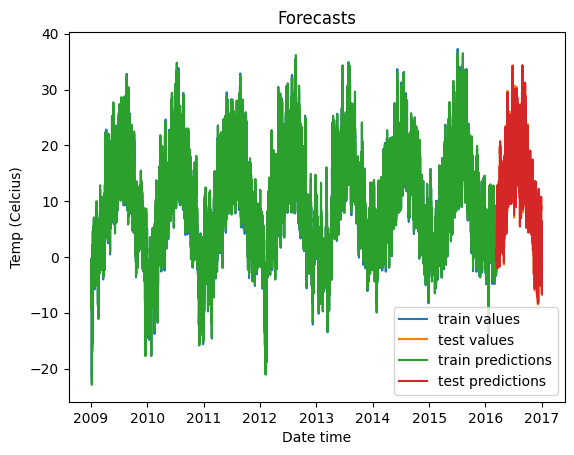

In [ ]:
X_test = sm.add_constant(X_test)

y_train_preds = result.predict(X_train)
y_test_preds = result.predict(X_test)

from matplotlib import pyplot as plt

# indexes start from 24 due to the window size we chose
plt.plot(pd.Series(y_train, index=train[24:].index), label='train values')
plt.plot(pd.Series(y_test, index=test[24:].index), label='test values')
plt.plot(pd.Series(y_train_preds, index=train[24:].index), label='train predictions')
plt.plot(pd.Series(y_test_preds, index=test[24:].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('Temp (Celcius)')
plt.title('Forecasts')
plt.legend()
plt.show()

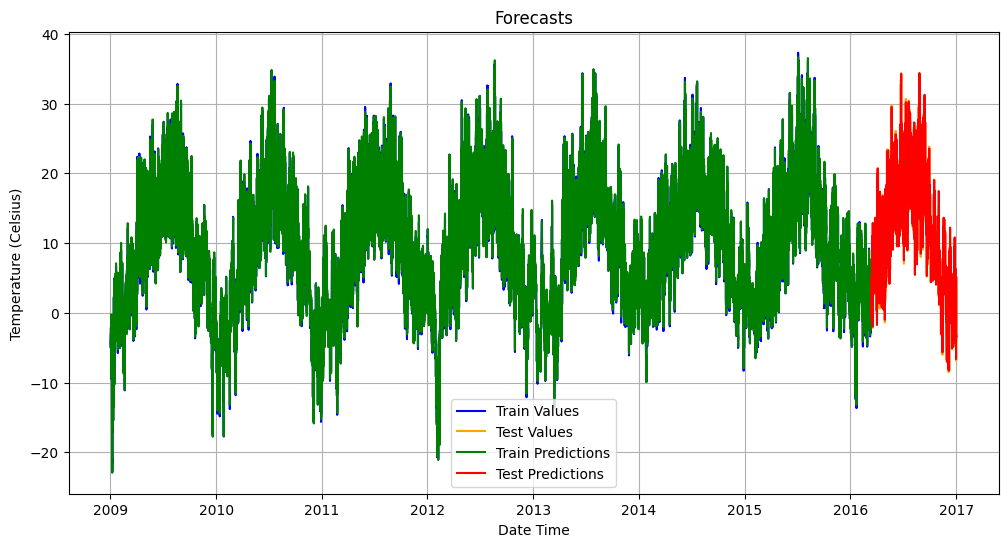

In [ ]:
import statsmodels.api as sm
import pandas as pd
from matplotlib import pyplot as plt

# Assuming you have your X_test, y_train, y_test, train, and test defined
X_test = sm.add_constant(X_test)

y_train_preds = result.predict(X_train)
y_test_preds = result.predict(X_test)

# Create the plot
plt.figure(figsize=(12, 6))  # Optional: set figure size
plt.plot(pd.Series(y_train, index=train[24:].index), label='Train Values', color='blue')
plt.plot(pd.Series(y_test, index=test[24:].index), label='Test Values', color='orange')
plt.plot(pd.Series(y_train_preds, index=train[24:].index), label='Train Predictions', color='green')
plt.plot(pd.Series(y_test_preds, index=test[24:].index), label='Test Predictions', color='red')
plt.xlabel('Date Time')
plt.ylabel('Temperature (Celsius)')
plt.title('Forecasts')
plt.legend()

# Add interactive zoom
plt.gca().set_autoscale_on(True)  # Allow auto-scaling
plt.grid(True)  # Optional: add grid for better visibility

# Show the plot
plt.show()


# Modelling Time Series With Recurrent Networks

We will look at different LSTM-based architectures for time series predictions. We will use PyTorch for our implementation.


We will test Vanilla LSTMs, Stacked LSTMs, Bidirectional LSTMs, and LSTMs followed by a fully-connected layer.


Before we do that, let's prepare our tensor datasets and dataloaders.


First we load the data.

In [ ]:
df = pd.read_csv('jena_climate_2009_2016.csv')

time_vals = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
series = df['T (degC)'][5::6]
series.index = time_vals[5::6]



# Then we create our test and train splits.

In [ ]:
# train test split
train = series[:-int(len(series)/10)]
train_idx = train.index
test = series[-int(len(series)/10):]
test_idx = test.index

We use the StandardScaler from scikit-learn to scale our data.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train = pd.Series(scaler.fit_transform(train.values.reshape(-1, 1))[:, 0], index=train_idx)
test = pd.Series(scaler.transform(test.values.reshape(-1, 1))[:, 0], index=test_idx)

And we use the lag matrix generation function we defined earlier to create our test and train datasets.

In [ ]:
window_size = 24

X_train, y_train = split_sequence(train, window_size=window_size)
X_test, y_test = split_sequence(test, window_size=window_size)


Then we convert all of this data into tensors, and subsequently a Torch TensorDataset and DataLoaders.

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader


# convert train and test data to tensors
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

# use torch tensor datasets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# get data loaders
batch_size = 32
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=batch_size)


Let's define the module that we will use to define our neural network architecture. We will make provisions for:


Vanilla LSTM

Stacked LSTM

Bidirectional LSTM

One fully-connected layer after the LSTM

In [ ]:
from torch import nn


class DenseLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_layers=1, bidirectional=False, dense=False):
        super(DenseLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layers = lstm_layers
        self.bidirectional = bidirectional
        self.dense = dense
        # define the LSTM layer
        self.lstm = nn.LSTM(input_size=self.input_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=self.layers,
                            bidirectional=self.bidirectional)
        self.act1 = nn.ReLU()
        # change linear layer inputs depending on if lstm is bidrectional
        if not bidirectional:
            self.linear = nn.Linear(self.hidden_dim, self.hidden_dim)
        else:
            self.linear = nn.Linear(self.hidden_dim * 2, self.hidden_dim)
        self.act2 = nn.ReLU()
        # change linear layer inputs depending on if lstm is bidrectional and extra dense layer isn't added
        if bidirectional and not dense:
            self.final = nn.Linear(self.hidden_dim * 2, 1)
        else:
            self.final = nn.Linear(self.hidden_dim, 1)


    def forward(self, inputs, labels=None):
        out = inputs.unsqueeze(1)
        out, h = self.lstm(out)
        out = self.act1(out)
        if self.dense:
            out = self.linear(out)
            out = self.act2(out)
        out = self.final(out)
        return out



# Now for the training function

In [ ]:
import time

def fit(model, optimizer, criterion):
    print("{:<8} {:<25} {:<25} {:<25}".format('Epoch',
                                          'Train Loss',
                                          'Test Loss',
                                          'Time (seconds)'))
    for epoch in range(epochs):
        model.train()
        start = time.time()
        epoch_loss = []
        # for batch in train data
        for step, batch in enumerate(train_dataloader):
            # make gradient zero to avoid accumulation
            model.zero_grad()
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            # get predictions
            out = model(inputs)
            out.to(device)
            # get loss
            loss = criterion(out, labels)
            epoch_loss.append(loss.float().detach().cpu().numpy().mean())
            # backpropagate
            loss.backward()
            optimizer.step()
        test_epoch_loss = []
        end = time.time()
        model.eval()
        # for batch in validation data
        for step, batch in enumerate(test_dataloader):
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            # get predictions
            out = model(inputs)
            # get loss
            loss = criterion(out, labels)
            test_epoch_loss.append(loss.float().detach().cpu().numpy().mean())
        print("{:<8} {:<25} {:<25} {:<25}".format(epoch+1,
                                                  np.mean(epoch_loss),
                                                  np.mean(test_epoch_loss),
                                                  end-start))




Now we can begin the training. We define the hidden layer sizes, epochs, loss function, and which optimizer we will use. Then we train the model and plot the predictions.

Epoch    Train Loss                Test Loss                 Time (seconds)           


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss

1        0.9873386025428772        0.6892463564872742        13.035930156707764       
2        0.9864098429679871        0.6263519525527954        4.6457133293151855       
3        0.9851535558700562        0.6138463020324707        5.624503135681152        
4        0.9855785965919495        0.6492236256599426        4.512914180755615        
5        0.9854279160499573        0.6508753299713135        5.582351207733154        
6        0.9850765466690063        0.6131166815757751        4.552656888961792        
7        0.9851480722427368        0.6122372150421143        4.58580207824707         


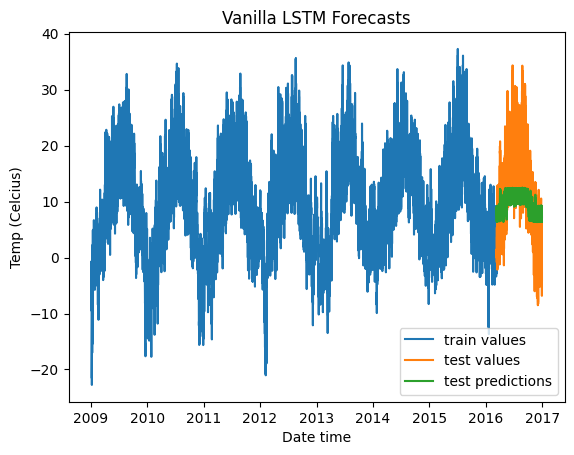

In [ ]:
# Check if GPU is available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

hidden_dim = 32
epochs = 7

# vanilla LSTM
model = DenseLSTM(window_size, hidden_dim, lstm_layers=1, bidirectional=False, dense=False)
model.to(device)

# define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# initate training
fit(model, optimizer, criterion)

# get predictions on validation set
model.eval()
preds = []
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    inputs, labels = batch
    out = model(inputs)
    preds.append(out)

preds = [x.float().detach().cpu().numpy() for x in preds]
preds = np.array([y for x in preds for y in x])

# plot data and predictions and applying inverse scaling on the data
plt.plot(pd.Series(scaler.inverse_transform(y_train.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=train[window_size:].index), label='train values')
plt.plot(pd.Series(scaler.inverse_transform(y_test.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test values')
plt.plot(pd.Series(scaler.inverse_transform(preds.reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('Temp (Celcius)')
plt.title('Vanilla LSTM Forecasts')
plt.legend()
plt.show()



To test out other LSTM architectures, you need to change just one line (besides the title of the plots). Test it out on a Gradient Community Notebook with a free GPU. But do make sure to reuse the entire snippet, because you would want to create a new optimizer and loss function instance every time you train a new model, too.



For Stacked LSTMs:

# For Stacked Bidirectional LSTMs:

Epoch    Train Loss                Test Loss                 Time (seconds)           


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss

1        0.9751327633857727        0.4779570996761322        11.946719408035278       
2        0.9688425064086914        0.3410816490650177        10.260788202285767       
3        0.9687855243682861        0.4319825768470764        10.607687711715698       
4        0.9704297184944153        0.4588622450828552        10.878068208694458       
5        0.9654675126075745        0.3910828232765198        11.02022910118103        


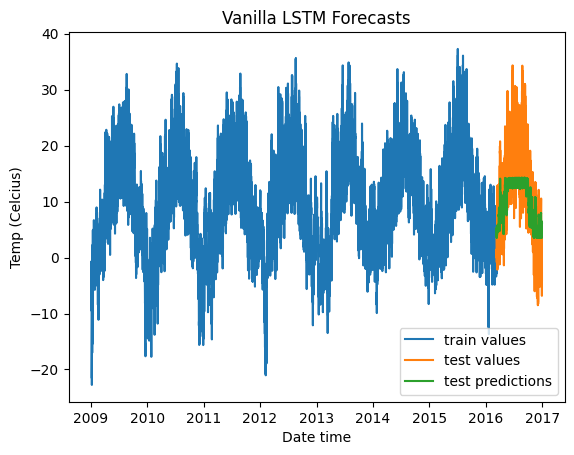

In [ ]:
# Check if GPU is available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

hidden_dim = 32
epochs = 5

# vanilla LSTM
# model = DenseLSTM(window_size, hidden_dim, lstm_layers=1, bidirectional=False, dense=False)
model = DenseLSTM(window_size, hidden_dim, lstm_layers=2, bidirectional=True, dense=False)

model.to(device)

# define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# initate training
fit(model, optimizer, criterion)

# get predictions on validation set
model.eval()
preds = []
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    inputs, labels = batch
    out = model(inputs)
    preds.append(out)

preds = [x.float().detach().cpu().numpy() for x in preds]
preds = np.array([y for x in preds for y in x])

# plot data and predictions and applying inverse scaling on the data
plt.plot(pd.Series(scaler.inverse_transform(y_train.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=train[window_size:].index), label='train values')
plt.plot(pd.Series(scaler.inverse_transform(y_test.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test values')
plt.plot(pd.Series(scaler.inverse_transform(preds.reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('Temp (Celcius)')
plt.title('Vanilla LSTM Forecasts')
plt.legend()
plt.show()



# For Stacked Bidirectional LSTMs:

Epoch    Train Loss                Test Loss                 Time (seconds)           


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss

1        0.9724152684211731        0.38102200627326965       18.230100393295288       
2        0.9700812101364136        0.399183064699173         10.933839559555054       
3        0.9695160388946533        0.3039456009864807        12.025140762329102       
4        0.971843957901001         0.3896234333515167        11.322519540786743       
5        0.9688386917114258        0.36921197175979614       11.262646675109863       


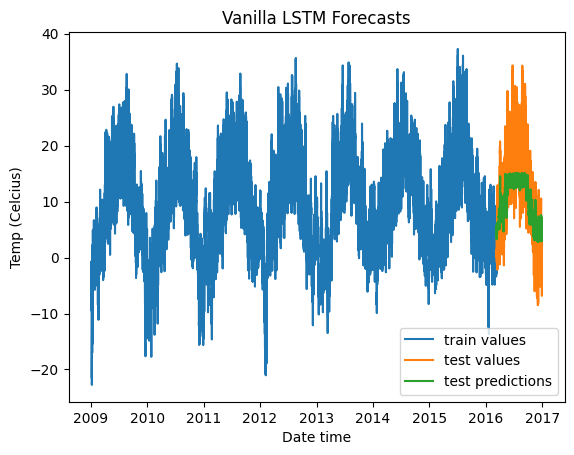

In [ ]:
# Check if GPU is available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

hidden_dim = 32
epochs = 5

# vanilla LSTM
# model = DenseLSTM(window_size, hidden_dim, lstm_layers=1, bidirectional=False, dense=False)
model = DenseLSTM(window_size, hidden_dim, lstm_layers=2, bidirectional=True, dense=False)

model.to(device)

# define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# initate training
fit(model, optimizer, criterion)

# get predictions on validation set
model.eval()
preds = []
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    inputs, labels = batch
    out = model(inputs)
    preds.append(out)

preds = [x.float().detach().cpu().numpy() for x in preds]
preds = np.array([y for x in preds for y in x])

# plot data and predictions and applying inverse scaling on the data
plt.plot(pd.Series(scaler.inverse_transform(y_train.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=train[window_size:].index), label='train values')
plt.plot(pd.Series(scaler.inverse_transform(y_test.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test values')
plt.plot(pd.Series(scaler.inverse_transform(preds.reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('Temp (Celcius)')
plt.title('Vanilla LSTM Forecasts')
plt.legend()
plt.show()



# For Stacked Bidirectional LSTMs with a fully-connected layer:

Epoch    Train Loss                Test Loss                 Time (seconds)           


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss

1        0.97225421667099          0.3854517340660095        13.637420892715454       
2        0.96998131275177          0.4569006860256195        11.951270818710327       
3        0.9689586162567139        0.3855668902397156        11.792560815811157       
4        0.9701683521270752        0.3629070222377777        11.499736547470093       
5        0.9700286984443665        0.3807511031627655        11.739689588546753       
6        0.9706441760063171        0.36283838748931885       12.165930271148682       


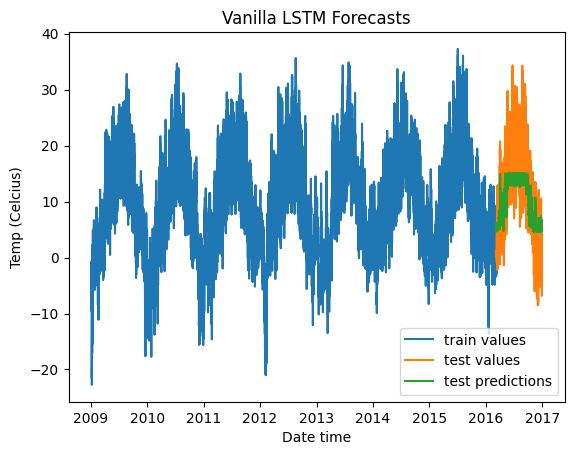

In [ ]:
# Check if GPU is available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


hidden_dim = 32
epochs = 6

# vanilla LSTM
# model = DenseLSTM(window_size, hidden_dim, lstm_layers=1, bidirectional=False, dense=False)
model = DenseLSTM(window_size, hidden_dim, lstm_layers=2, bidirectional=True, dense=True)

model.to(device)

# define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# initate training
fit(model, optimizer, criterion)

# get predictions on validation set
model.eval()
preds = []
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    inputs, labels = batch
    out = model(inputs)
    preds.append(out)

preds = [x.float().detach().cpu().numpy() for x in preds]
preds = np.array([y for x in preds for y in x])

# plot data and predictions and applying inverse scaling on the data
plt.plot(pd.Series(scaler.inverse_transform(y_train.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=train[window_size:].index), label='train values')
plt.plot(pd.Series(scaler.inverse_transform(y_test.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test values')
plt.plot(pd.Series(scaler.inverse_transform(preds.reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('Temp (Celcius)')
plt.title('Vanilla LSTM Forecasts')
plt.legend()
plt.show()

